# Crypto Sentiment Analysis and Price Correlation

### AJ Valenty and Ziyana Samanani
Welcome! Below is our notebook for our sentiment analysis on crypto prices and correlation with predicting prices with a focus on intraday price prediction. Link to our paper here. 

## Initial Setup

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
#Change this flag if you're using google colab
#This is so we can get the hourly data from the web if needed
usingGoogleColab = False

In [3]:
import ssl #Only for Google colab

def setup(usingGoogleColab):
    global btc_df
    global df
    
    if usingGoogleColab:
        filepath = 'https://www.cryptodatadownload.com/cdd/Bitstamp_BTCUSD_1h.csv'
        ssl._create_default_https_context = ssl._create_unverified_context
        btc_df = pd.read_csv(filepath, skiprows=1)
    else:
        btc_df = pd.read_csv('Bitstamp_BTCUSD_1h.csv')

    # Load bitcoin tweets
    df = pd.read_csv('Bitcoin_tweets.csv')

setup(usingGoogleColab)

/Users/ajvalenty/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3357: DtypeWarning: Columns (1,2,3,5,6,7,8,9,10,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


## Data Analysis: Missing Data and Data Type Setup




In [4]:
df_len = len(df)
df_na = (df_len - df.count())/df_len

df_na = df_na.drop(df_na[df_na == 0].index).sort_values(ascending=False)[:30]
missing_data = pd.DataFrame({'Missing Ratio' :df_na})
missing_data.head(20)

,Missing Ratio
user_location,0.530440
user_description,0.203016
hashtags,0.142374
source,0.134549
is_retweet,0.132619
user_followers,0.118551
user_friends,0.118551
user_favourites,0.118551
user_verified,0.118551
date,0.118551


In [5]:
df.dtypes

user_name            object
user_location        object
user_description     object
user_created         object
user_followers      float64
user_friends         object
user_favourites      object
user_verified        object
date                 object
text                 object
hashtags             object
source               object
is_retweet           object
dtype: object

## Malformed Data
As you can see, we must remove missing values and set the appropriate data types. For one, we do not neeed user_location, source, and user_created, as they are irrelevant to our model.

There is also random data entries for the the date, which we remove manually.

In [4]:
#Remove entire column: user_location, source, and user_created (not relevant to the model) 
df = df.drop(['user_location', 'source', 'user_created'], axis=1)

#Remove entire row where text is missing (extremely relevant to model)
df_text = df['text']
idx_drop = []
text_miss = df_text.isnull()

for i in range(len(text_miss)):
    if text_miss[i] == True:
        idx_drop.append(i)

#Remove entire row where date is missing
df_date = df['date']
idx_drop2 = []
date_miss = df_date.isnull()

for i in range(len(date_miss)):
      if date_miss[i] == True:
        idx_drop2.append(i)

for num in idx_drop2:
    if num not in idx_drop:
        idx_drop.append(num)

df = df.drop(idx_drop)

# Get indexes where date field is abnormal
# Delete these row indexes from dataFrame
indexNames = df[df['date'] == "['ETH', 'BTC', 'Bitcoin']"].index
df.drop(indexNames , inplace=True)

indexNames = df[df['date'] == "['cryptocurrency', 'BSC', 'Bitcoin', 'Ethereum', 'ETH', 'Airdrop', 'bounty', 'ESHOP', 'Airdrops']"].index
df.drop(indexNames , inplace=True)

indexNames = df[df['date'] == "['YieldFarming', 'Airdrop', 'Binance', 'Bitcoin', 'pancakeswap', 'BNB', 'cryptocurrency', 'DeFi', 'BTC', 'BinanceSmartChain', 'BSC', 'pufferswap', 'DeFi', 'bsc', 'bnb', 'bitcoin', 'cryto', 'Airdrop', 'Airdrop']"].index
df.drop(indexNames , inplace=True)

indexNames = df[df['date'] == "['btc']"].index
df.drop(indexNames , inplace=True)

indexNames = df[df['date'] == "['YieldFarming', 'Airdrop', 'PancakeSwap', 'Giveaway', 'BTC', 'BNB', 'Binance', 'BSC', 'cryptocurrency']"].index
df.drop(indexNames , inplace=True)

indexNames = df[df['date'] == "['Bitcoin']"].index
df.drop(indexNames , inplace=True)

indexNames = df[df['date'] == "['cryptotrading', 'crypto', 'tradingbots', 'bitcoin', 'btc']"].index
df.drop(indexNames , inplace=True)

indexNames = df[df['date'] == "['PW', 'pythonwealth', 'Presale', 'token', 'ico', 'BSC', 'Binance', 'smartchain', 'blockchain', 'coin', 'airdrop', 'launch', 'token_presale', 'poocoin', 'pinksale', 'pancakeswap', 'bitcoin', 'btc']"].index
df.drop(indexNames , inplace=True)

indexNames = df[df['date'] == "['bitcoin']"].index
df.drop(indexNames , inplace=True)

indexNames = df[df['date'] == "['cryptotrading', 'tradingbots', 'altcoins', 'bitcoin']"].index
df.drop(indexNames , inplace=True)

indexNames = df[df['date'] == "['cryptotrading', 'tradingbots', 'altcoins', 'bitcoin', 'trading', 'crypto', 'security']"].index
df.drop(indexNames , inplace=True)

#Set proper types for our dataframes
df['date'] = df['date'].astype('datetime64[ns]')
df['user_friends'] = df['user_friends'].astype('float64')
df['user_verified'] = df['user_verified'].astype('bool')
df["hashtags"]=df["hashtags"].apply(lambda s : s[1:-1].split(',') if isinstance(s,str) else [])



In [68]:
btc_df = btc_df.reset_index(drop=False)
btc_df = btc_df.rename(columns={'level_0': 'unix', 'level_1': 'date', 'level_2': 'symbol', 'level_3': 'open', 'level_4': 'high', 'level_5': 'low', 'level_6': 'close', 'level_7': 'Volume BTC', 'https://www.CryptoDataDownload.com': 'Volume USD'})
btc_df = btc_df.drop(0)
btc_df['date'] = btc_df['date'].astype('string')
btc_df['date'] = btc_df['date'].astype('datetime64[ns]')
btc_df['symbol'] = btc_df['symbol'].astype('string')
btc_df['open'] = btc_df['open'].astype('float64')
btc_df['high'] = btc_df['high'].astype('float64')
btc_df['low'] = btc_df['low'].astype('float64')
btc_df['close'] = btc_df['close'].astype('float64')
btc_df['Volume BTC'] = btc_df['Volume BTC'].astype('float64')
btc_df['Volume USD'] = btc_df['Volume USD'].astype('float64')

## Sentiment Analysis

Now that we have clean data, let's install the proper packages for sentiment analysis and compute the sentiment for each tweet we have. We can weight the sentiment based on the z score of the user's follower count, and calculate and impact score based on whether the user is verified, favourite count, and hashtag length

In [10]:
#We are using textblob sentiment library for our sentiment analysis
!pip install -U textblob

In [6]:
from textblob import TextBlob
import math

follower_mean = df['user_followers'].mean()
follower_std = df['user_followers'].std()


def computeSentimentAnalysis(sentences, followers):
    sentiment = 0
    
    #Calculate polarity
    blob = TextBlob(sentences)
    
    #Take the max polarity value for multiple sentence tweets
    for i in blob.sentences:
        if abs(i.sentiment.polarity) > abs(sentiment):
            sentiment = i.sentiment.polarity

    z_score = (followers - follower_mean) / follower_std
    weight = z_score
    
    if z_score < 1: #If the z_score is less than average, keep it's weight
        weight = 1
    else:
        #Otherwise, weight quadratically if you have more followers than average.
        weight = abs(z_score) ** 2

    if sentiment > 0:
        return 1, 1 * (weight)
    elif sentiment == 0:
        return 0, 0
    else:
        return -1, -1 * (weight)


In [9]:
#Example sentiment
computeSentimentAnalysis("I hate BTC. It has no purpose and just wait until regulations come.", 200000)

(-1, -2.8057631685060427)

In [7]:
for idx, row in df.iterrows():
    sentiment, weighted = computeSentimentAnalysis(str(row['text']), row['user_followers'])
    df.at[idx, 'sentiment'] = sentiment
    df.at[idx, 'weighted_sentiment'] = weighted
# df['sentiment'] = df['sentiment'].apply(computeSentimentAnalysis, axis=1)

In [8]:
#Using a sample influencer score calculator online
def computeInfluencerScore(row):
    coef_verified = 1.1 if row.user_verified else 1
    coef_hashtags = 1+(len(row.hashtags)/20)
    return ((row.user_followers + (row.user_friends/4))*coef_verified*coef_hashtags)/100
    

In [9]:
df["influencer_score"] = df.apply(computeInfluencerScore, axis=1)

In [10]:
df['weighted_sentiment'].describe()

count    1.513416e+06
mean     7.107818e-01
std      6.897904e+01
min     -1.403078e+04
25%      0.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      4.273975e+04
Name: weighted_sentiment, dtype: float64

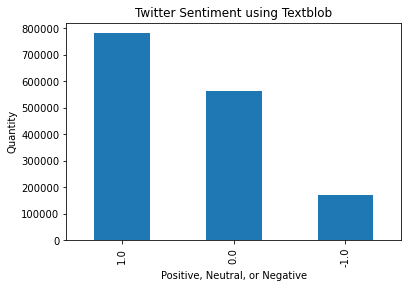

In [14]:
df['sentiment'].value_counts().plot(kind="bar")
plt.title("Twitter Sentiment using Textblob")
plt.xlabel("Positive, Neutral, or Negative")
plt.ylabel("Quantity")
plt.show()

### A sentiment has been created for all tweets. Now we must join them into hourly/6-hourly/daily groupings.

In [11]:
hourly_df = df.copy()
twelve_df = df.copy()

In [22]:
df.dtypes

user_name                     object
user_description              object
user_followers               float64
user_friends                 float64
user_favourites               object
user_verified                   bool
date                  datetime64[ns]
text                          object
hashtags                      object
is_retweet                    object
sentiment                    float64
weighted_sentiment           float64
influencer_score             float64
dtype: object

In [23]:
import datetime
import numpy as np

#Round time to the nearest roundTo Value
def roundTime(dt, roundTo):
    seconds = (dt.replace(tzinfo=None) - dt.min).seconds
    rounding = (seconds+roundTo/2) // roundTo * roundTo
   
    return dt + datetime.timedelta(0,rounding-seconds,-dt.microsecond)

In [17]:
#Sample of rounding the time down to 6 hours
print(roundTime(datetime.datetime(2012,12,31,3,29,59,1234),roundTo=60*60*6))


2012-12-31 06:00:00


#### Round all tweets to a provided interval

We will round all tweets to an inputted time interval. timeInt refers to hourly rounding

In [24]:
def roundDFTime(frame, timeInt):
    #Round all the tweets times to hourly
    roundedTime = []
    for index, row in frame.iterrows():
        roundedTime.append(roundTime(row['date'].to_pydatetime(), 60*60*timeInt))

    return roundedTime

In [25]:
df['date'] = roundDFTime(df, 6)
hourly_df['date'] = roundDFTime(hourly_df, 1)
twelve_df['date'] = roundDFTime(twelve_df, 12)

##### We have 314 data points for 6 hours worth of data, which is approximately 52 days. This seems about right given our tweet data

In [28]:
len(df['date'].unique())

314

#### Calculate average sentiment given the time period.

In [29]:
def calcAverages(input_df):
    data = {'date': [],
    'sentiment': [],
    'weighted_sentiment': [],
    'influencer_score': [],
    'volume': []}

    #Initial dataframe
    dff = pd.DataFrame(data)
    index = 0
    sentiment = 0

    for d in input_df['date'].unique():
        #Iterate over unique dates (hours)
        hourly_sentiment = 0
        hourly_count = 0
        hourly_w_sentiment = 0
        hourly_influence = 0
        
        for idx, row in input_df[input_df['date'] == d].iterrows():
            #Iterate over the values where the date is the same
            hourly_count += 1

            #Compute the hourly total sentiment
            hourly_sentiment += row['sentiment']
            hourly_w_sentiment += row['weighted_sentiment']
            hourly_influence += row['influencer_score']

        hour = pd.Series(data={'date': d, 'influencer_score': hourly_influence / hourly_count, 'sentiment': hourly_sentiment / hourly_count, 'weighted_sentiment': hourly_w_sentiment / hourly_count, 'volume': hourly_count}, name=str(index))

        dff = dff.append(hour, ignore_index=True)
        index += 1
    dff['date'] = dff['date'].astype('datetime64[ns]')
    return dff
        

In [30]:
new_df = calcAverages(df)
hourly_df = calcAverages(hourly_df)
twelve_df = calcAverages(twelve_df)

#### Now, we will prep the BTC data by removing unnessecary dates and round them to the same time, meaning all times within a specific interval will be rounded to the start of the interval.

In [69]:
min_date = min(new_df['date'])
max_date = max(new_df['date'])
counter = 0

#Remove BTC prices where the dates aren't in the twitter dataset
for index, row in btc_df.iterrows():
    if row['date'] < min_date or row['date'] > max_date:
        counter += 1
        btc_df.drop(index)

print("Rows removed:")
print(counter)

Rows removed:
24606


In [70]:
def roundBTCTime(df_copy, timeInt):

    #Round all the tweets times to hourly
    roundedTime = []
    for index, row in df_copy.iterrows():
        roundedTime.append(roundTime(row['date'].to_pydatetime(), 60*60*timeInt))

    return roundedTime
    

In [71]:
#For hourly and twelve hourly
btc_df1 = btc_df.copy()
btc_df2 = btc_df.copy()

#Round all times
btc_df['date'] = roundBTCTime(btc_df, 6)
btc_df1['date'] = roundBTCTime(btc_df1, 1)
btc_df2['date'] = roundBTCTime(btc_df2, 12)

#### Compute the new close and open values for the new intervals beyond 1 hour.

In [62]:
def computeCloseOpenIntervals(df_copy, timeInt):
    #Compute new close and open times for the respective intervals
    crypto_df = pd.DataFrame()
    index = 0

    #Only need to compute this if we aren't doing hourly
    for d in df_copy['date'].unique():
        #Iterate over unique dates (hours)
        count = 0
        maxIndex = 0
        for idx, row in df_copy[df_copy['date'] == d].iterrows():
            if count == 0:
                openVal = row['open']

            maxIndex = max(idx, maxIndex)
            if maxIndex == idx:
                closeVal = row['close']
            count = 1


        hour = pd.Series(data={'date': d, 'open': openVal, 'close': closeVal}, name=str(index))
        crypto_df = crypto_df.append(hour, ignore_index=True)
        index += 1
    
    crypto_df['date'] = crypto_df['date'].astype('datetime64[ns]')
    return crypto_df

In [75]:
#Only need to do this for 12 and 6 hours, as we already have one hour close and open data
btc_df2 = computeCloseOpenIntervals(btc_df2, 12)
btc_df = computeCloseOpenIntervals(btc_df, 6)


#### Calculate the difference and direction in the closing price of the interval and the opening price of the interval.

In [77]:
#Calculate diff variable, closing - open price

def computeDiff(df_copy):
    difference = []
    direction = []
    for index, row in df_copy.iterrows():
        diff = row['close'] - row['open']
        if diff >= 0:
            direction.append(1)
        else:
            direction.append(0)
    
        difference.append(diff)
        
    return difference, direction

diff, dire = computeDiff(btc_df)
btc_df['diff'] = diff
btc_df['direction'] = dire

diff1, dire1 = computeDiff(btc_df1)
btc_df1['diff'] = diff1
btc_df1['direction'] = dire1

diff2, dire2 = computeDiff(btc_df2)
btc_df2['diff'] = diff2
btc_df2['direction'] = dire2


#### Look into what the BTC data looks like:

In [78]:
btc_df

,close,date,open,diff,direction
0,59646.68,2021-11-21 00:00:00,59785.85,-139.17,0
1,57663.13,2021-11-20 18:00:00,59522.26,-1859.13,0
2,58539.57,2021-11-20 12:00:00,58551.56,-11.99,0
3,58591.79,2021-11-20 06:00:00,58440.31,151.48,1
4,57850.24,2021-11-20 00:00:00,58851.45,-1001.21,0
...,...,...,...,...,...
5139,8164.79,2018-05-16 06:00:00,8232.99,-68.20,0
5140,8492.28,2018-05-16 00:00:00,8326.28,166.00,1
5141,8520.30,2018-05-15 18:00:00,8555.60,-35.30,0
5142,8708.32,2018-05-15 12:00:00,8759.23,-50.91,0


#### Inner join the data sets based on the date

In [79]:
btc_df['date'] = btc_df['date'].astype('datetime64[ns]')
btc_df1['date'] = btc_df1['date'].astype('datetime64[ns]')
btc_df2['date'] = btc_df2['date'].astype('datetime64[ns]')

six_df = pd.merge(btc_df, new_df, how='inner')
hourly_df = pd.merge(btc_df1, hourly_df, how='inner')
twelve_df = pd.merge(btc_df2, twelve_df, how='inner')

def getIndexFeature(df_copy):
    idx = []
    for i in range(len(df_copy)):
        idx.append(i)
    return idx

six_df['index'] = getIndexFeature(six_df)
hourly_df['index'] = getIndexFeature(hourly_df)
twelve_df['index'] = getIndexFeature(twelve_df)

In [81]:
twelve_df1 = twelve_df.copy()
six_df1 = six_df.copy()
hourly_df1 = hourly_df.copy()

#### Add previous 1 time increment, 7, and 30 to each row 

Labeled day, week, and month for simplicity

In [82]:
def computePrevSentiment(df_cop):
    df_copy = df_cop.copy()
    
    w_sent_mean = df_copy['weighted_sentiment'].mean()
    sent_mean = df_copy['sentiment'].mean()

    # Add prev_day, week, and month to df
    for idx, row in df_copy.iterrows():
        if idx != 0:
            df_copy.at[idx, 'prev_day_sentiment'] = df_copy['sentiment'][idx - 1]
            df_copy.at[idx, 'w_prev_day_sentiment'] = df_copy['weighted_sentiment'][idx - 1]
        else:
            df_copy.at[idx, 'prev_day_sentiment'] = sent_mean
            df_copy.at[idx, 'w_prev_day_sentiment'] = w_sent_mean


        if idx >= 7:
            prev_week_sent = 0
            w_prev_week_sent = 0
            for i in range(idx - 7, idx):
                prev_week_sent += df_copy['sentiment'][i]
                w_prev_week_sent += df_copy['weighted_sentiment'][i]

            df_copy.at[idx, 'prev_week_sentiment'] = prev_week_sent / 7.0
            df_copy.at[idx, 'w_prev_week_sentiment'] = w_prev_week_sent / 7.0
        else:
            df_copy.at[idx, 'prev_week_sentiment'] = sent_mean
            df_copy.at[idx, 'w_prev_week_sentiment'] = w_sent_mean


        if idx >= 30:
            prev_month_sent = 0
            w_prev_month_sent = 0
            for j in range(idx - 30, idx):
                prev_month_sent += df_copy['sentiment'][i]
                w_prev_month_sent += df_copy['weighted_sentiment'][i]
                
            df_copy.at[idx, 'prev_month_sentiment'] = prev_month_sent / 30.0
            df_copy.at[idx, 'w_prev_month_sentiment'] = w_prev_month_sent / 7.0

        else:
            df_copy.at[idx, 'prev_month_sentiment'] = sent_mean
            df_copy.at[idx, 'w_prev_month_sentiment'] = w_sent_mean
    return df_copy

six_df = computePrevSentiment(six_df)
hourly_df = computePrevSentiment(hourly_df)
twelve_df = computePrevSentiment(twelve_df)

In [84]:
def computeChangeFeature(df_cop):
    df_copy = df_cop.copy()
    # If there is an positive change in sentiment, mark it as a 1.
    # If there is a negative change in sentiment, mark it as a 0.
    for idx, row in df_copy.iterrows():
        if row['weighted_sentiment'] > row['w_prev_day_sentiment']:
            df_copy.at[idx, 'day_change'] = 1
        else:
            df_copy.at[idx, 'day_change'] = 0

        if row['weighted_sentiment'] > row['w_prev_week_sentiment']:
            df_copy.at[idx, 'week_change'] = 1
        else:
            df_copy.at[idx, 'week_change'] = 0

        if row['weighted_sentiment'] > row['w_prev_month_sentiment']:
            df_copy.at[idx, 'month_change'] = 1
        else:
            df_copy.at[idx, 'month_change'] = 0
    return df_copy

six_df = computeChangeFeature(six_df)
hourly_df = computeChangeFeature(hourly_df)
twelve_df = computeChangeFeature(twelve_df)

#### Adding features on if the date of the tweet is on Friday, Monday, beginning, or end of the month

We believe there is stronger inclination for bigger moves in the market on Fridays, Mondays, beginning, end of the month. End of months usually cause selloffs or rallies towards specific targets. Beginning of the month can cause rallies.

In [86]:
def computeRallyTime(df_copy):
    #Constants
    MONDAY = 0
    FRIDAY = 4

    isRallyTime = []

    for date in df_copy['date']:
        if date.weekday() == FRIDAY or date.weekday() == MONDAY:
            isRallyTime.append(1)
        elif date.day / date.days_in_month >= 3/4 or date.day / date.days_in_month <= 1/4:
            isRallyTime.append(1)
        else:
            isRallyTime.append(0)
    return isRallyTime
        
six_df['isRallyTime'] = computeRallyTime(six_df)
hourly_df['isRallyTime'] = computeRallyTime(hourly_df)
twelve_df['isRallyTime'] = computeRallyTime(twelve_df)

### SFS

Computation for features is complete, below is our dataset prepped for analysis

In [248]:
six_df

,close,date,open,diff,direction,sentiment,weighted_sentiment,influencer_score,volume,index,prev_day_sentiment,w_prev_day_sentiment,prev_week_sentiment,w_prev_week_sentiment,prev_month_sentiment,w_prev_month_sentiment,day_change,week_change,month_change,isRallyTime
0,61044.46,2021-10-24 00:00:00,60985.52,58.94,1,0.350298,0.375087,51.220556,1847.0,0,0.368465,0.711055,0.368465,0.711055,0.368465,0.711055,0.0,0.0,0.0,1
1,61461.17,2021-10-23 18:00:00,60989.45,471.72,1,0.430100,0.475177,77.011235,11123.0,1,0.350298,0.375087,0.368465,0.711055,0.368465,0.711055,1.0,0.0,0.0,0
2,60657.24,2021-10-23 12:00:00,61364.96,-707.72,0,0.454265,0.519963,81.088917,12321.0,2,0.430100,0.475177,0.368465,0.711055,0.368465,0.711055,1.0,0.0,0.0,0
3,61247.06,2021-10-23 06:00:00,60885.90,361.16,1,0.436416,0.524749,61.555760,9743.0,3,0.454265,0.519963,0.368465,0.711055,0.368465,0.711055,1.0,0.0,0.0,0
4,60396.76,2021-10-23 00:00:00,61021.46,-624.70,0,0.375949,0.525525,108.839081,9488.0,4,0.436416,0.524749,0.368465,0.711055,0.368465,0.711055,1.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,39929.15,2021-02-06 12:00:00,40183.29,-254.14,0,0.287109,0.490309,109.145025,1024.0,309,0.280047,0.287379,0.363644,0.290383,0.280047,1.231625,1.0,1.0,0.0,1
310,39396.40,2021-02-06 06:00:00,39378.81,17.59,1,0.307179,0.317669,34.668661,599.0,310,0.287109,0.490309,0.352172,0.348003,0.287109,2.101324,0.0,0.0,0.0,1
311,37861.99,2021-02-06 00:00:00,38858.47,-996.48,0,0.266369,0.266369,49.756510,672.0,311,0.307179,0.317669,0.353377,0.350706,0.307179,1.361440,0.0,0.0,0.0,1
312,38000.00,2021-02-05 18:00:00,37665.76,334.24,1,0.261072,0.301954,63.869608,858.0,312,0.266369,0.266369,0.345172,0.371198,0.266369,1.141582,1.0,0.0,0.0,1


In [240]:
# install mlxtend if you haven't installed one before
! pip install mlxtend
! pip install joblib
! pip install sklearn --upgrade
! pip install joblib --upgrade
import joblib
import mlxtend

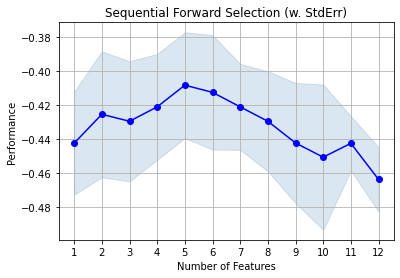

In [245]:
# Import sequenctial features selector as SFS
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs

#Forward feature selector
six_hour_MA = model_analysis(six_df)

lr = LogisticRegression()
sfs = SFS(lr, k_features=(1,12), forward=True, scoring='neg_mean_absolute_error', cv=3, n_jobs=-1)

sfs = sfs.fit(six_hour_MA.cX_train, six_hour_MA.cy_train)

fig = plot_sfs(sfs.get_metric_dict(), kind='std_err')

plt.title('Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

#### Performance looked better with less features, but because we had spoken with Dr. Sano about adding more features, we decided to stick with the 12 we have.

<AxesSubplot:title={'center':'BTC Price Over Time'}, xlabel='date'>

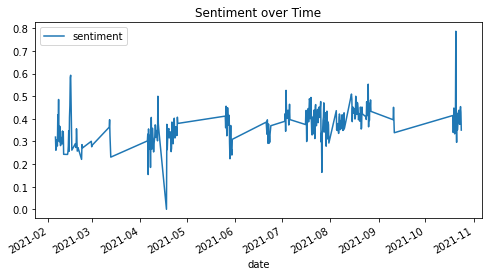

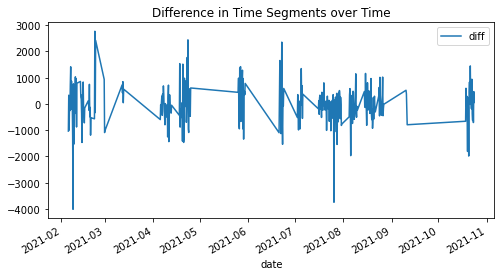

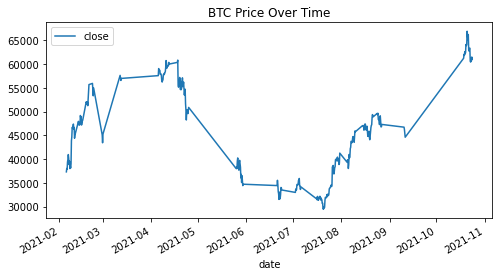

In [97]:
six_df.plot.line('date', 'sentiment', figsize=(8,4), title='Sentiment over Time') 
six_df.plot.line('date', 'diff', figsize=(8,4), title='Difference in Time Segments over Time') 
six_df.plot.line('date', 'close', figsize=(8,4), title='BTC Price Over Time')

## Modeling: Linear, Polynomial, Logistic, and LSTM

Now, we will look at some models and evaluate their effectiveness

In [98]:
six_df['date'] = six_df['date'].astype('string')
six_df['date'] = pd.to_datetime(six_df['date'])

hourly_df['date'] = hourly_df['date'].astype('string')
hourly_df['date'] = pd.to_datetime(hourly_df['date'])

twelve_df['date'] = twelve_df['date'].astype('string')
twelve_df['date'] = pd.to_datetime(twelve_df['date'])

### Class structure: efficient modularity for the amount of dataframes and models we need to run

In [127]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
import seaborn as sns
import numpy as np
%matplotlib inline
from sklearn import metrics


class model_analysis:
    def __init__(self, df):
        self.df = df
        self.features = df[['sentiment', 'weighted_sentiment', 'w_prev_day_sentiment', 'w_prev_week_sentiment', 'w_prev_month_sentiment', 'prev_day_sentiment', 'prev_week_sentiment', 'prev_month_sentiment', 'week_change', 'day_change', 'month_change', 'isRallyTime']]
        self.close_label = df[['close']]
        self.direction_label = df[['direction']]
        self.cX_train, self.cX_test, self.cy_train, self.cy_test = self.train_test(self.features, self.direction_label)
        self.X_train, self.X_test, self.y_train, self.y_test = self.train_test(self.features, self.close_label)
        self.logreg = None
        
    def train_test(self, features, label):
        return train_test_split(features, label, test_size=0.25, random_state=0)
    
    def linearRegression(self, xtrain, ytrain, xtest, ytest):
        reg = LinearRegression().fit(xtrain, ytrain)
        return reg.score(xtest, ytest)
    
    def polynomialRegression(self, xtrain, ytrain, xtest, ytest, deg=3):
        # Fitting Polynomial Regression to the dataset
        poly_reg = PolynomialFeatures(degree=3)
        X_poly_train = poly_reg.fit_transform(xtrain)
        pol_reg = LinearRegression()
        pol_reg.fit(X_poly_train, ytrain)

        X_poly_test = poly_reg.fit_transform(xtest)
        return pol_reg.score(X_poly_test, ytest)
    
    def logisticRegression(self, xtrain, ytrain, xtest, ytest):
        self.logreg = LogisticRegression()
        self.logreg.fit(xtrain, ytrain.values.ravel())
        y_pred = self.logreg.predict(xtest)
        y_train_pred = self.logreg.predict(xtrain)
        
        print("On Test Data")
        print("Accuracy:",metrics.accuracy_score(ytest, y_pred))
        print("Precision:",metrics.precision_score(ytest, y_pred))
        print("Recall:",metrics.recall_score(ytest, y_pred))


        print("\nOn Training Data, just to see for potential overfitting")
        print("Accuracy:",metrics.accuracy_score(ytrain, y_train_pred))
        print("Precision:",metrics.precision_score(ytrain, y_train_pred))
        print("Recall:",metrics.recall_score(ytrain, y_train_pred))
        
        return y_pred
    
    def computeConfusionMatrix(self, y_pred, y_test):
        cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
        class_names=[0,1] # name  of classes
        fig, ax = plt.subplots()
        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names)
        plt.yticks(tick_marks, class_names)
        # create heatmap
        sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
        ax.xaxis.set_label_position("top")
        plt.tight_layout()
        plt.title('Confusion matrix', y=1.1)
        plt.ylabel('Actual label')
        plt.xlabel('Predicted label')
    
    def computeROC(self):
        y_pred_proba = self.logreg.predict_proba(self.cX_test)[::,1]
        fpr, tpr, _ = metrics.roc_curve(self.cy_test,  y_pred_proba)
        auc = metrics.roc_auc_score(self.cy_test, y_pred_proba)
        plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
        plt.legend(loc=4)
        plt.title('ROC Curve')
        plt.show()


        
    

### 6 hour interval Linear, Polynomial, and Logistic Regression

In [129]:
six_hour_MA.linearRegression(six_hour_MA.X_train, six_hour_MA.y_train, six_hour_MA.X_test, six_hour_MA.y_test)

0.10727786392175309

In [130]:
six_hour_MA.polynomialRegression(six_hour_MA.X_train, six_hour_MA.y_train, six_hour_MA.X_test, six_hour_MA.y_test)

-10194463935.203163

In [131]:
prediction = six_hour_MA.logisticRegression(six_hour_MA.cX_train, six_hour_MA.cy_train, six_hour_MA.cX_test, six_hour_MA.cy_test)

On Test Data
Accuracy: 0.5569620253164557
Precision: 0.42857142857142855
Recall: 0.3870967741935484

On Training Data, just to see for potential overfitting
Accuracy: 0.5531914893617021
Precision: 0.5444444444444444
Recall: 0.4336283185840708


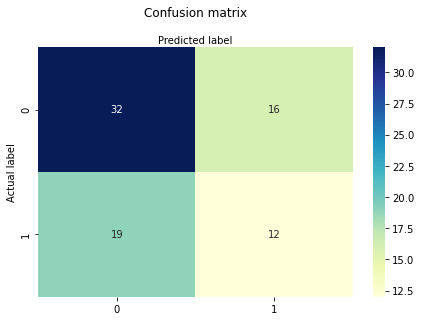

In [132]:
six_hour_MA.computeConfusionMatrix(prediction, six_hour_MA.cy_test)

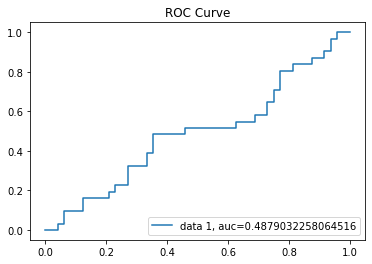

In [133]:
six_hour_MA.computeROC()

### Hourly interval Linear, Polynomial, and Logistic Regression

In [135]:
hourly_MA = model_analysis(hourly_df)

hourly_MA.linearRegression(hourly_MA.X_train, hourly_MA.y_train, hourly_MA.X_test, hourly_MA.y_test)

0.1603325129538118

In [136]:
hourly_MA.polynomialRegression(hourly_MA.X_train, hourly_MA.y_train, hourly_MA.X_test, hourly_MA.y_test)

-11.08971844508644

In [137]:
prediction = hourly_MA.logisticRegression(hourly_MA.cX_train, hourly_MA.cy_train, hourly_MA.cX_test, hourly_MA.cy_test)

On Test Data
Accuracy: 0.4988814317673378
Precision: 0.5226480836236934
Recall: 0.6329113924050633

On Training Data, just to see for potential overfitting
Accuracy: 0.5343796711509716
Precision: 0.5337915234822451
Recall: 0.6832844574780058


/Users/ajvalenty/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


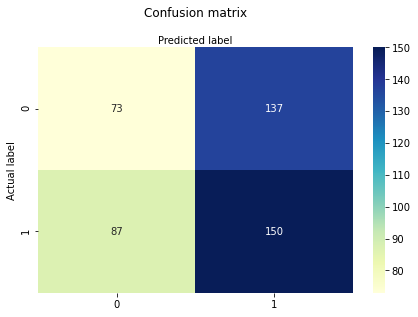

In [138]:
hourly_MA.computeConfusionMatrix(prediction, hourly_MA.cy_test)

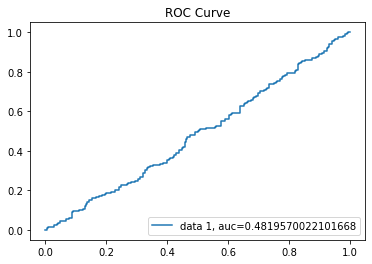

In [139]:
hourly_MA.computeROC()

### 12 Hour Interval Linear, Polynomial, and Logistic Regression

In [140]:
twelve_MA = model_analysis(twelve_df)

twelve_MA.linearRegression(twelve_MA.X_train, twelve_MA.y_train, twelve_MA.X_test, twelve_MA.y_test)

0.23843916345052485

In [142]:
twelve_MA.polynomialRegression(twelve_MA.X_train, twelve_MA.y_train, twelve_MA.X_test, twelve_MA.y_test)

-9219.37090248611

In [144]:
prediction = twelve_MA.logisticRegression(twelve_MA.cX_train, twelve_MA.cy_train, twelve_MA.cX_test, twelve_MA.cy_test)

On Test Data
Accuracy: 0.35714285714285715
Precision: 0.391304347826087
Recall: 0.4090909090909091

On Training Data, just to see for potential overfitting
Accuracy: 0.5447154471544715
Precision: 0.5384615384615384
Recall: 0.5737704918032787


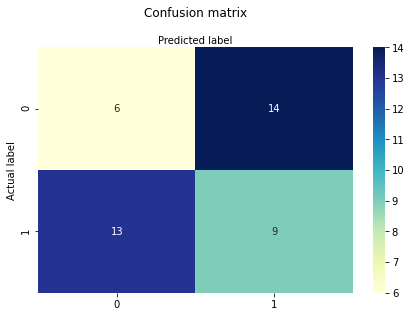

In [145]:
twelve_MA.computeConfusionMatrix(prediction, twelve_MA.cy_test)

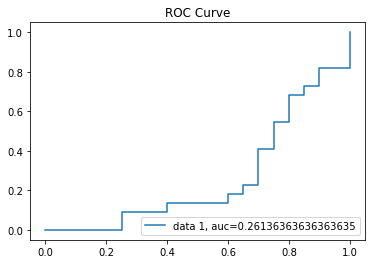

In [146]:
twelve_MA.computeROC()

#### Linear and Polynomial Regression are obviously very inaccurate, this makes sense. We just wanted to see what the score would look like. We are mainly focused on Logistic Regression and LSTM.

#### For Logistic Regression, accuracy is okay, where 6 hourly performance the best for the Logistic Regression with an accuracy of 0.56.

We would've expected a better result for 12 hour, but our dataset is quite small for 12 hour- this is likely a factor.

## LSTM Model: Computing Price Prediction

In [226]:
#Used this tutorial for LSTM: https://towardsdatascience.com/single-and-multi-step-temperature-time-series-forecasting-for-vilnius-using-lstm-deep-learning-b9719a0009de

def transformLSTMData(inputData, lag, n_ahead, target_index=0):

    # Extracting the number of features that are passed from the array 
    n_features = inputData.shape[1]
    
    X, Y = [], []

    if len(inputData) - lag <= 0:
        X.append(inputData)
    else:
        for i in range(len(inputData) - lag - n_ahead):
            Y.append(inputData[(i + lag):(i + lag + n_ahead), target_index])
            X.append(inputData[i:(i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an RNN input shape 
    X = np.reshape(X, (X.shape[0], lag, n_features))

    return X, Y

### Definitions of variables

In [203]:
# # of time intervals back to use for models
lag = 20

# Steps ahead to forecast 
forecast = outputs = 1

# Epochs for training
epochs = 40

# Batch size 
batch_size = 28

In [218]:
import tensorflow as tf
import keras
from keras.layers import Dense, Input, Dropout, LSTM
from keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow import keras
from tensorflow.keras import layers
from keras import losses
from keras.callbacks import ModelCheckpoint, EarlyStopping

#Class for modularity and ease of using our multiple dataframes
class LSTMModel:
    def __init__(self, X_train, y_train, X_val, y_val, shape):
        self.X_train = X_train
        self.y_train = y_train
        self.X_val = X_val
        self.y_val = y_val
        self.shape = shape
        self.model = None
        
    def trainLSTM(self):
        input_ = Input(shape=(20, self.shape))
        
        lstm = LSTM(10, activation='relu')(input_)
        
        dense_ = Dense(forecast)(lstm)
        self.model = Model(inputs=input_, outputs=dense_)
        self.model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=0.001))
        return self.model.fit(self.X_train, self.y_train, epochs=40, batch_size=batch_size, validation_data=(self.X_val, self.y_val), shuffle=False)

    def predictLSTM(self, X):
        return self.model.predict(X)
        

In [252]:
from sklearn.metrics import r2_score, mean_squared_error

def runLSTM(df_copy, MA): 
    pred = df_copy[['close', 'sentiment', 'weighted_sentiment', 'w_prev_day_sentiment', 'w_prev_week_sentiment', 'w_prev_month_sentiment', 'prev_day_sentiment', 'prev_week_sentiment', 'prev_month_sentiment', 'week_change', 'day_change', 'month_change', 'isRallyTime']]
    
    # Train and test_set
    rows = pred.shape[0]
    train = pred[0:int(rows * (.9))]
    test = pred[int(rows * (.9)):]

    # Normalizing the data 
    train_mean = train.mean()
    train_std = train.std()
    train = (train-train_mean) / train_std
    test = (test-train_mean) / train_std
    price_pred_cat = pd.concat([train, test])

    # Creating the X and Y for training
    X, Y = transformLSTMData(price_pred_cat.values, 20, n_ahead=forecast)

    #Train and test sets 
    Xtrain, Ytrain = X[0:int(X.shape[0] * (1-test_share))], Y[0:int(X.shape[0] * .9)]
    Xval, Yval = X[int(X.shape[0] * (1-test_share)):], Y[int(X.shape[0] * .9):]
    lstm_model = LSTMModel(Xtrain, Ytrain, Xval, Yval, X.shape[2])

    history = lstm_model.trainLSTM()
    return lstm_model, Xval, Yval, train_mean, train_std


def computeScore(X_test, y_test, lstm_model):
    y_pred = [x[0] for x in lstm_model.predictLSTM(X_test)]
    y_test_2 = [x[0] for x in y_test]

    print("R2 score : %.2f" % r2_score(y_test_2, y_pred))
    print("Mean squared error: %.2f" % mean_squared_error(y_test_2,y_pred))
    
def graphPrediction(X_test, Y_test, lstm_model, df_copy, train_mean, train_std, timeInt):
    
    #Get prediction and y_test set
    y_predictions = [x[0] for x in lstm_model.predictLSTM(X_test)]
    y = [y[0] for y in Y_test]
    
    days = df_copy['date'].values[-len(y):]
    
    graphFrame = pd.concat([
     pd.DataFrame({'date': days, 'close': y, 'type': 'original'}),
     pd.DataFrame({'date': days, 'close': y_predictions, 'type': 'forecast'})
    ])
    
    #Unnormalize the close price
    graphFrame['close_unnormal'] = [(x * train_std['close']) + train_mean['close'] for x in graphFrame['close']]
    
    #Graph both forecast and original
    pivoted = graphFrame.pivot_table(index='date', columns='type')
    pivoted.columns = ['_'.join(x).strip() for x in pivoted.columns.values]
    plt.figure(figsize=(12, 12))
    plt.plot(pivoted.index, pivoted.close_unnormal_original, color='blue', label='original')
    plt.plot(pivoted.index, pivoted.close_unnormal_forecast, color='red', label='forecast')
    plt.title('BTC Price Prediction for ' + timeInt + ' hour interval')
    plt.legend()
    plt.show()

In [230]:
lstm_model_six, six_xval, six_yval, six_mean, six_std = runLSTM(six_df, six_hour_MA)


Epoch 1/40
10/10 [==============================] - 1s 22ms/step - loss: 0.5567 - val_loss: 0.1941
Epoch 2/40
10/10 [==============================] - 0s 7ms/step - loss: 0.4970 - val_loss: 0.1938
Epoch 3/40
10/10 [==============================] - 0s 7ms/step - loss: 0.4537 - val_loss: 0.1955
Epoch 4/40
10/10 [==============================] - 0s 7ms/step - loss: 0.4101 - val_loss: 0.1975
Epoch 5/40
10/10 [==============================] - 0s 7ms/step - loss: 0.3654 - val_loss: 0.2002
Epoch 6/40
10/10 [==============================] - 0s 7ms/step - loss: 0.3162 - val_loss: 0.2072
Epoch 7/40
10/10 [==============================] - 0s 7ms/step - loss: 0.2601 - val_loss: 0.2270
Epoch 8/40
10/10 [==============================] - 0s 7ms/step - loss: 0.2166 - val_loss: 0.2610
Epoch 9/40
10/10 [==============================] - 0s 6ms/step - loss: 0.1890 - val_loss: 0.2920
Epoch 10/40
10/10 [==============================] - 0s 6ms/step - loss: 0.1747 - val_loss: 0.2773
Epoch 11/40
10/10 

R2 score : 0.27
Mean squared error: 0.11


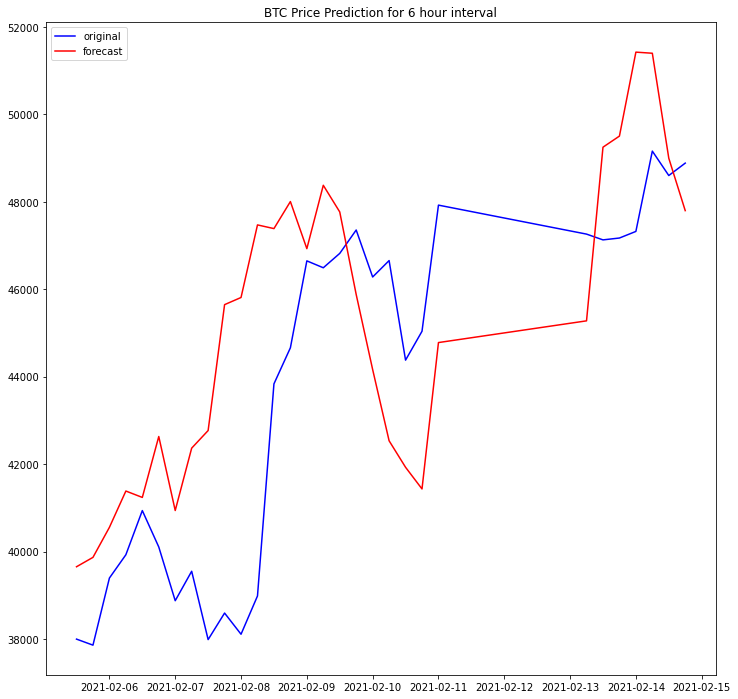

In [253]:
computeScore(six_xval, six_yval, lstm_model_six)
graphPrediction(six_xval, six_yval, lstm_model_six, six_df, six_mean, six_std, '6')

In [232]:
lstm_model_hour, hour_xval, hour_yval, hour_mean, hour_std = runLSTM(hourly_df, hourly_MA)


Epoch 1/40
57/57 [==============================] - 1s 7ms/step - loss: 2.1326 - val_loss: 1.1514
Epoch 2/40
57/57 [==============================] - 0s 4ms/step - loss: 1.0658 - val_loss: 0.7273
Epoch 3/40
57/57 [==============================] - 0s 4ms/step - loss: 0.5221 - val_loss: 0.4373
Epoch 4/40
57/57 [==============================] - 0s 4ms/step - loss: 0.2810 - val_loss: 0.3470
Epoch 5/40
57/57 [==============================] - 0s 4ms/step - loss: 0.1818 - val_loss: 0.3322
Epoch 6/40
57/57 [==============================] - 0s 4ms/step - loss: 0.1331 - val_loss: 0.2767
Epoch 7/40
57/57 [==============================] - 0s 6ms/step - loss: 0.1065 - val_loss: 0.2508
Epoch 8/40
57/57 [==============================] - 0s 5ms/step - loss: 0.0942 - val_loss: 0.2218
Epoch 9/40
57/57 [==============================] - 0s 5ms/step - loss: 0.0793 - val_loss: 0.1959
Epoch 10/40
57/57 [==============================] - 0s 5ms/step - loss: 0.0703 - val_loss: 0.1790
Epoch 11/40
57/57 [

R2 score : 0.72
Mean squared error: 0.04


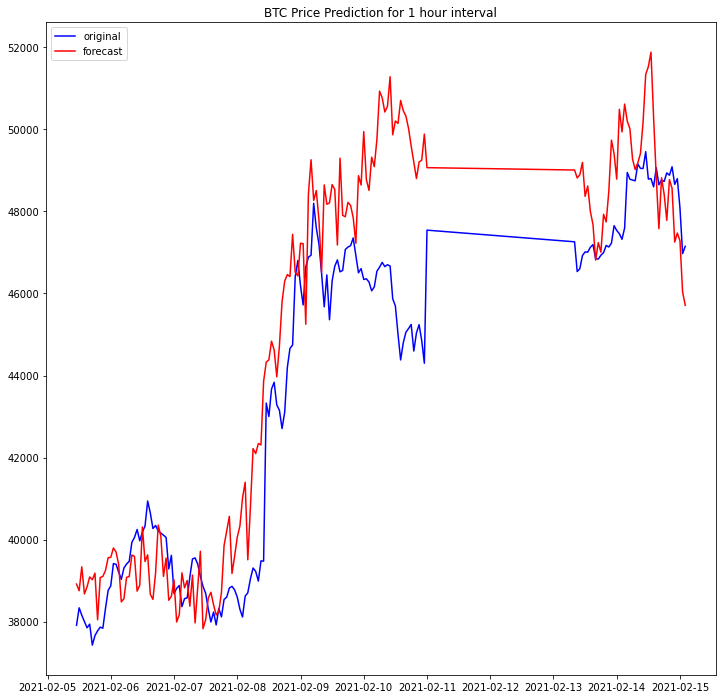

In [254]:
computeScore(hour_xval, hour_yval, lstm_model_hour)
graphPrediction(hour_xval, hour_yval, lstm_model_hour, hourly_df, hour_mean, hour_std, '1')

In [238]:
lstm_model_12, twelve_xval, twelve_yval, twelve_mean, twelve_std = runLSTM(twelve_df, twelve_MA)


Epoch 1/40
5/5 [==============================] - 1s 53ms/step - loss: 2.0632 - val_loss: 0.7632
Epoch 2/40
5/5 [==============================] - 0s 10ms/step - loss: 1.7073 - val_loss: 0.5685
Epoch 3/40
5/5 [==============================] - 0s 10ms/step - loss: 1.4300 - val_loss: 0.4194
Epoch 4/40
5/5 [==============================] - 0s 10ms/step - loss: 1.2093 - val_loss: 0.3166
Epoch 5/40
5/5 [==============================] - 0s 10ms/step - loss: 1.0372 - val_loss: 0.2524
Epoch 6/40
5/5 [==============================] - 0s 10ms/step - loss: 0.9000 - val_loss: 0.2210
Epoch 7/40
5/5 [==============================] - 0s 14ms/step - loss: 0.7845 - val_loss: 0.2185
Epoch 8/40
5/5 [==============================] - 0s 11ms/step - loss: 0.6904 - val_loss: 0.2422
Epoch 9/40
5/5 [==============================] - 0s 10ms/step - loss: 0.6183 - val_loss: 0.2877
Epoch 10/40
5/5 [==============================] - 0s 10ms/step - loss: 0.5672 - val_loss: 0.3428
Epoch 11/40
5/5 [============

R2 score : -0.95
Mean squared error: 0.32


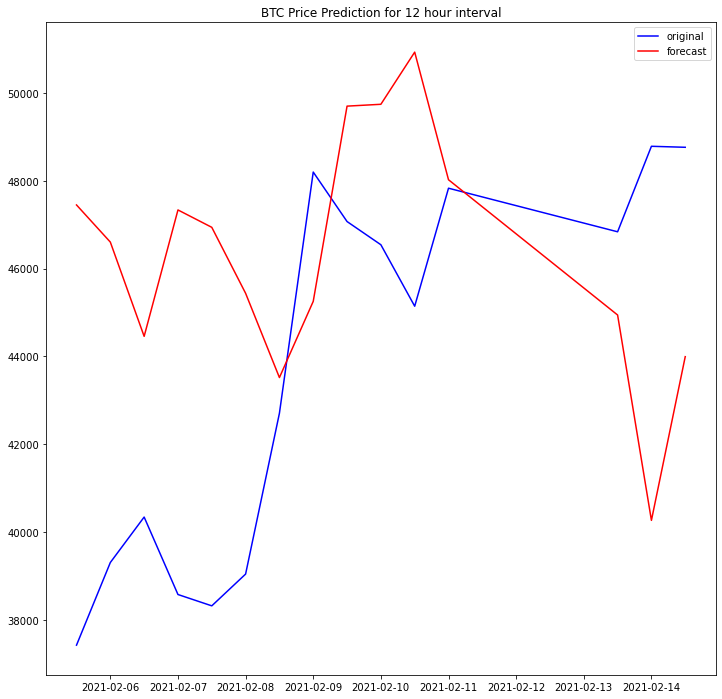

In [255]:
computeScore(twelve_xval, twelve_yval, lstm_model_12)
graphPrediction(twelve_xval, twelve_yval, lstm_model_12, twelve_df, twelve_mean, twelve_std, '12')

### As you can see, hourly performs the best while the 6 hourly also performs well. We equate 12 hourly failure due to lack of data.

Ultimately, we believe that it is quite difficult to predict price of twitter sentiment. 

We believe our project had a fair amount of bottlenecks in comparison to some other projects on similar topics, such as not using a trained sentiment analysis library for stock/investor context, not having enough data for larger time intervals, and not using other sources of data such as Google trends. But, I do think it was interesting to see how the LSTM differed from logistic regression, comparing continuous vs. classification. I think this was a great learning experience for us to get our hands dirty!